In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

In [12]:
activation = pd.read_excel('data/Activations.xlsx')

In [13]:
activation.head()

,Start Date,Activations
0,2021-02-01,4
1,2021-02-08,157
2,2021-02-15,125
3,2021-02-22,77
4,2021-03-01,58


In [14]:
activation.set_index('Start Date', inplace = True)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

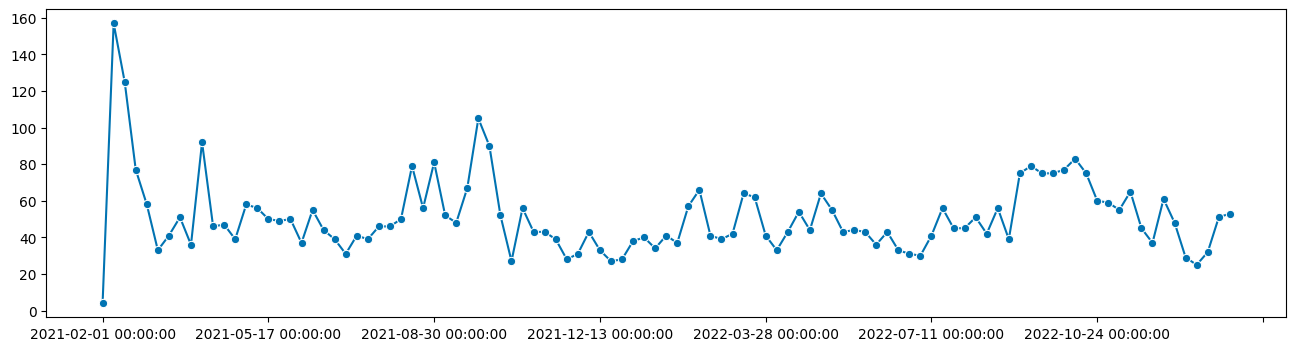

In [15]:
plot_series(activation)

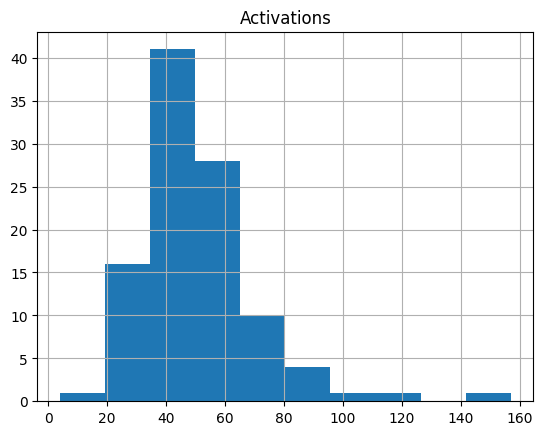

In [7]:
activation.hist()
plt.show()

In [25]:
activation.describe()

,Activations
count,103.000000
mean,51.038835
std,20.915292
min,4.000000
25%,39.000000
50%,46.000000
75%,57.500000
max,157.000000


# **Time series analysis using statsmodels**

### **Stationarity Test**

**Augmented Dickey-Fuller Test for Stationarity**

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
adftest = adfuller(activation)
print(f'ADF Statistic: {adftest[0]}')
print(f'p-value: {adftest[1]}')

p_thresh = 0.05

if adftest[1] < p_thresh: 
    print(f'We can reject our null hypothesis (p = {adftest[1]}) at our significance level of {p_thresh}. The time series is stationary')
else: 
    print(f'We cannot reject our null hypothesis (p = {adftest[1]}) at our significance level of {p_thresh}. The time series is non-stationary')

ADF Statistic: -3.892510097181161
p-value: 0.0020906653685437166
We can reject our null hypothesis (p = 0.0020906653685437166) at our significance level of 0.05. The time series is stationary


The ADF Test is a statistical test that demonstrates whether a time-series is stationary (mean and variance are constant; although stationarity is a complex definition). The ADF Test enables this, by checking whether a unit root is present in the characteristic equation applied to the function

### **Autocorrelation Functions**



**Autocorrelation Function (ACF)**

Text(0, 0.5, 'ACF')

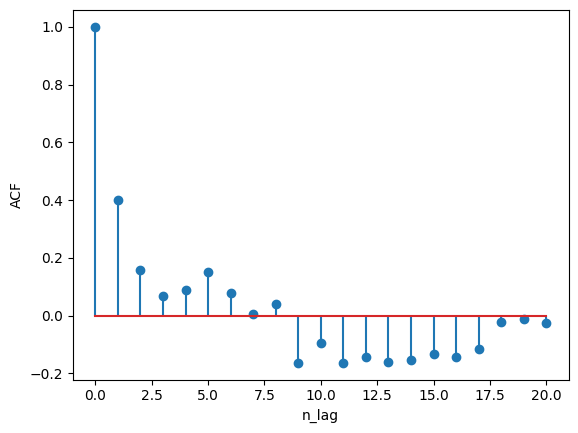

In [13]:
acf = sm.tsa.stattools.acf(activation, nlags = 20)
plt.stem(acf)
plt.xlabel('n_lag')
plt.ylabel('ACF')

The ACF calculates the correlation between our variable indexed at time t and our variable lagged at some value of k $\geq$ 0

**Partial Autocorrelation Function (PACF)**

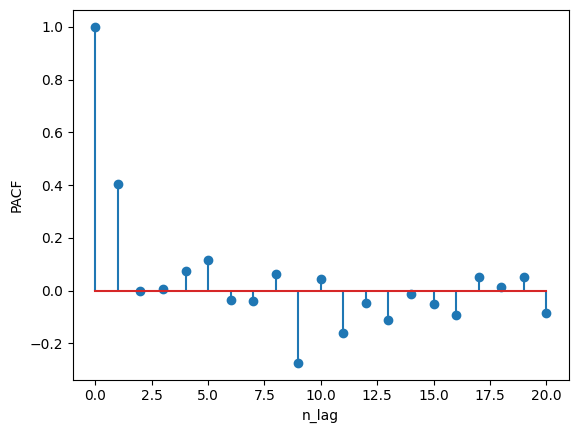

In [16]:
pacf = sm.tsa.stattools.pacf(activation, nlags = 20)
plt.stem(pacf)
plt.xlabel('n_lag')
plt.ylabel('PACF')
plt.show()

The ACF calculates the correlation between our variable indexed at time t and our variable lagged at some value of k $\geq$ 0 after accounting for the effect of the intervening variables between lag k

### **White Noise Test**

**Portmanteau (Q) Test using Ljung-Box Implementation**

In [26]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [41]:
w_test = acorr_ljungbox(activation['Activations'], lags=20, return_df=True, boxpierce=False)
w_test

,lb_stat,lb_pvalue
1,16.892843,0.000040
2,19.600412,0.000055
3,20.104195,0.000162
4,20.984903,0.000319
5,23.528990,0.000267
6,24.188587,0.000482
7,24.192680,0.001054
8,24.366875,0.001989
9,27.451852,0.001177
10,28.498107,0.001502


In [46]:
if any(w_test['lb_pvalue'] > 0.05):
    print("We reject the null hypothesis that the activation data is a white noise")
else:
    print("We cannot reject the null hypothesis that the activation data is a white noise")

We cannot reject the null hypothesis that the activation data is a white noise


**Test for Seasonality, Trend, and Residuals**

We don't seem to have enough data to calculate a seasonal decompositon

In [1]:
# from statsmodels.tsa.seasonal import seasonal_decompose

### **Outlier Detection** 

IQR Outlier Detection, also known as the Box-Whiskers Plot

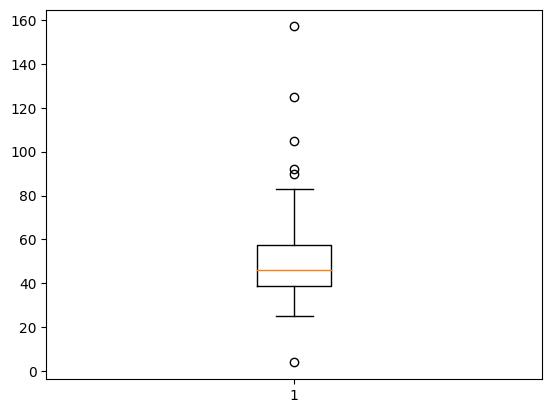

In [9]:
plt.boxplot(activation['Activations'].values)
plt.show()

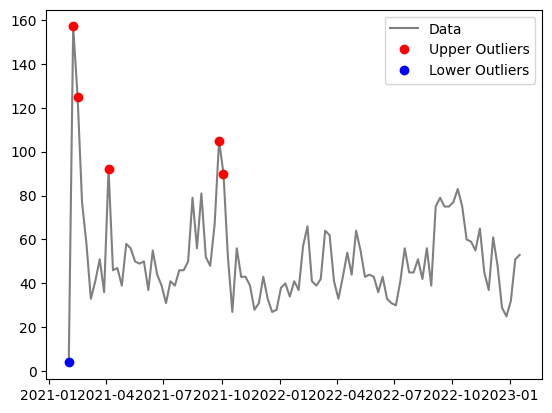

In [47]:
q1 = np.quantile(activation, 0.25)
q3 = np.quantile(activation, 0.75)

iqr = q3-q1

filter = [(activation['Activations'] <= (q1 - (1.5*iqr))) | (activation['Activations'] >= (q3 + (1.5*iqr)))]

lower = np.ma.masked_where(activation['Activations'] <= (q1 - (1.5*iqr)), activation['Activations'])
upper = np.ma.masked_where(activation['Activations'] >= (q3 + (1.5*iqr)), activation['Activations']) 

plt.plot(activation.index, activation['Activations'], color='gray', label='Data')
plt.plot(activation[upper.mask].index, activation[upper.mask]['Activations'], 'o', color = 'red', label='Upper Outliers')
plt.plot(activation[lower.mask].index, activation[lower.mask]['Activations'], 'o', color = 'blue', label='Lower Outliers')
plt.legend()
plt.show()

### **Forecasting using Sktime**

Using the ForecastingHorizon Object

In [60]:
activation.tail(6)

,Activations
2022-12-12,48
2022-12-19,29
2022-12-26,25
2023-01-02,32
2023-01-09,51
2023-01-16,53


In [16]:
from sktime.forecasting.base import ForecastingHorizon

## Ensuring our forecasting horizons is configured to the last 6 periods, which effectively is passed into our temporal_test_train_split for predictions. This can be modified to your liking
fh = ForecastingHorizon(pd.date_range('2022-12-12', periods = 6, freq = 'W-MON'), is_relative = False)
fh

ForecastingHorizon(['2022-12-12', '2022-12-19', '2022-12-26', '2023-01-02',
               '2023-01-09', '2023-01-16'],
              dtype='datetime64[ns]', freq='W-MON', is_relative=False)

In [49]:
train, test = temporal_train_test_split(activation['Activations'], fh=fh)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

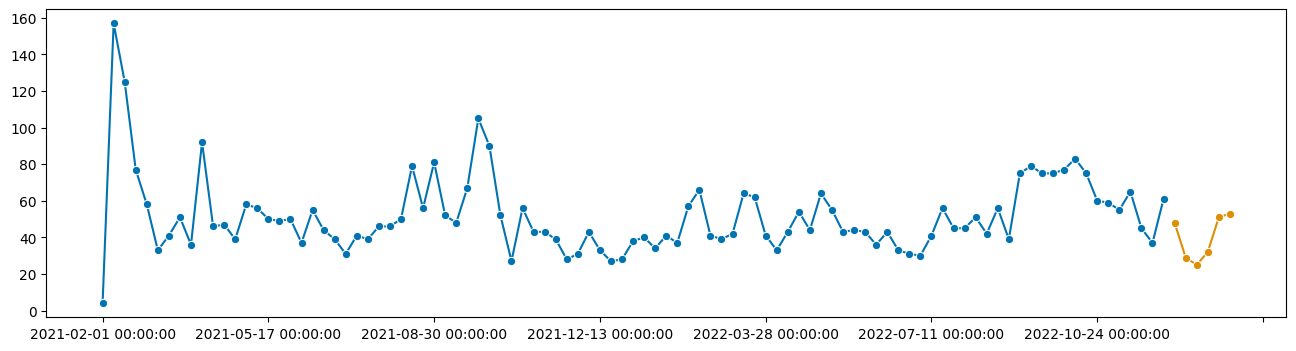

In [57]:
plot_series(train, test)

In [ ]:
## Ready for forecasting